In [1]:
import os
import glob
import sys
sys.path.append('/hkfs/work/workspace/scratch/cc7738-automorphism/orbit-gnn/')  # Replace with the actual path

# Specify the folder path
folder_path = '/hkfs/work/workspace/scratch/cc7738-automorphism/orbit-gnn'

# Use glob to get all the PDF files in the folder
pdf_files = glob.glob(os.path.join(folder_path, '*.pdf'))

# Loop through all the files and delete them
for pdf_file in pdf_files:
    try:
        os.remove(pdf_file)
        print(f"Deleted: {pdf_file}")
    except Exception as e:
        print(f"Error deleting {pdf_file}: {e}")


/home/hk-project-test-p0021478/cc7738/anaconda3/envs/EAsF/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of orbits: 2303, Dataset: Cora, LCC size: 2485


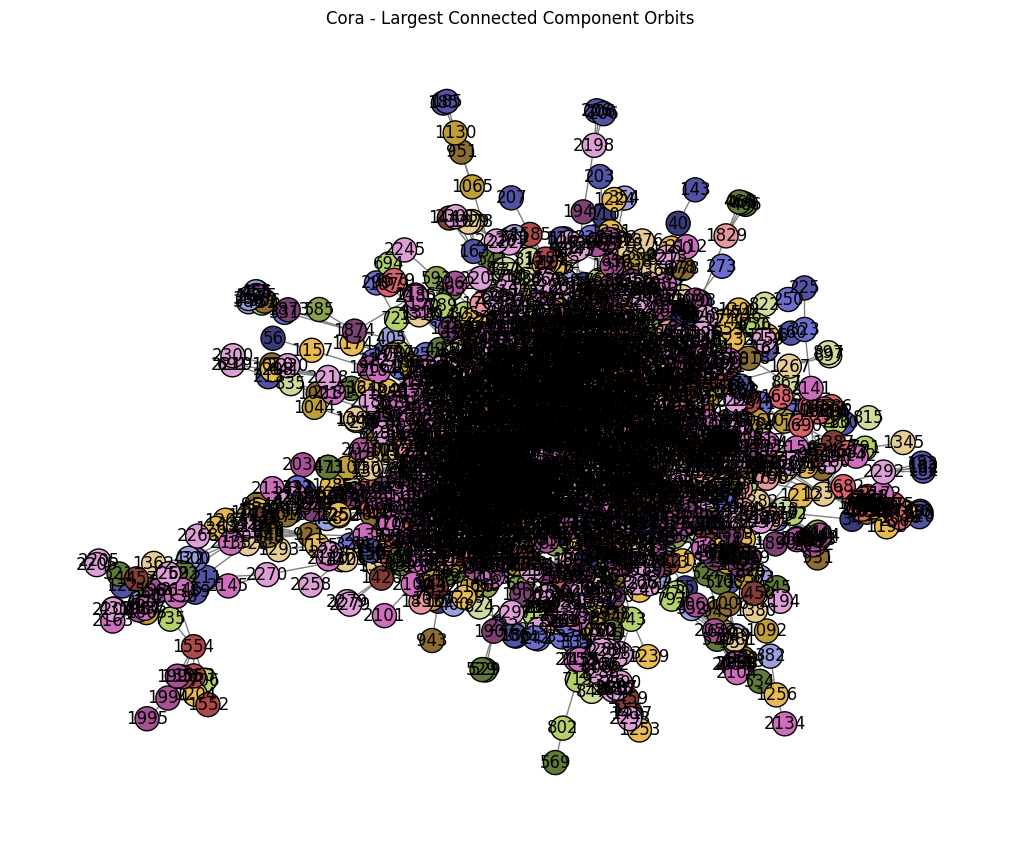

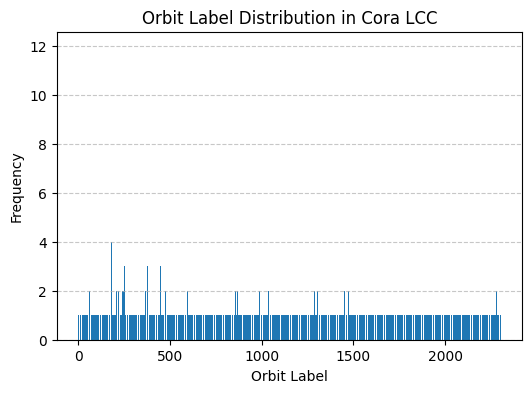

In [2]:
import networkx as nx
import pynauty
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

# Choose dataset: "Cora" or "Citeseer"
dataset_name = 'Cora'  # Change to 'Citeseer' if needed
dataset = Planetoid(root=f'/tmp/{dataset_name}', name=dataset_name)
data = dataset[0]

# Convert PyG graph to NetworkX and relabel nodes to integers
G_nx = to_networkx(data, to_undirected=True)
G_nx = nx.convert_node_labels_to_integers(G_nx)

# Extract the largest connected component
largest_cc_nodes = max(nx.connected_components(G_nx), key=len)
G_lcc = G_nx.subgraph(largest_cc_nodes).copy()
G_lcc = nx.convert_node_labels_to_integers(G_lcc)  # Relabel again for pynauty

n = len(G_lcc.nodes)
pos = nx.spring_layout(G_lcc, seed=42)

# Build adjacency dict for pynauty
adj_dict = {node: list(G_lcc.neighbors(node)) for node in G_lcc.nodes()}
G_pynauty = pynauty.Graph(number_of_vertices=n, adjacency_dict=adj_dict, directed=False)
generators, _, _, orbits, num_orbit = pynauty.autgrp(G_pynauty)

# Normalize orbit labels
new_label_mapping = {node: idx for idx, node in enumerate(set(orbits))}
orbits = [new_label_mapping[orbit] for orbit in orbits]

print(f"Number of orbits: {num_orbit}, Dataset: {dataset_name}, LCC size: {n}")

# Node colors and labels
node_colors = [orbits[node] for node in range(n)]
custom_labels = {idx: str(orbit) for idx, orbit in enumerate(orbits)}

# Draw LCC with orbits
plt.figure(figsize=(10, 8))
nx.draw(
    G_lcc,
    pos,
    with_labels=True,
    labels=custom_labels,
    node_color=node_colors,
    cmap='tab20b',
    node_size=300,
    edge_color="gray",
    edgecolors='black'
)
plt.title(f"{dataset_name} - Largest Connected Component Orbits")
plt.show()
plt.close()

# Histogram of orbits
plt.figure(figsize=(6, 4))
plt.hist(orbits, bins=range(min(orbits), max(orbits) + 2), align='left', rwidth=0.8)
plt.xlabel('Orbit Label')
plt.ylabel('Frequency')
plt.title(f'Orbit Label Distribution in {dataset_name} LCC')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
plt.close()

In [3]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import itertools 
# Settings
graph_type = 'ER'  # 'ER' for Erdős-Rényi, 'BA' for Barabási-Albert
n = 1000  # Nodes in each copy of H
m_random_edges = 1000  # Number of additional random edges

# Step 1: Generate graph H
if graph_type == 'ER':
    p = 0.01  # Probability for edge creation
    H = nx.erdos_renyi_graph(n, p, seed=42)
elif graph_type == 'BA':
    m = 3  # Edges to attach from a new node to existing nodes
    H = nx.barabasi_albert_graph(n, m, seed=42)
else:
    raise ValueError("Invalid graph_type. Use 'ER' or 'BA'.")

# Step 2: Create G as disjoint union of two copies of H
H1 = nx.convert_node_labels_to_integers(H, first_label=0)
H2 = nx.convert_node_labels_to_integers(H, first_label=n)
G = nx.disjoint_union(H1, H2)


In [4]:
# Step 3: Automorphism analysis on G0
adj0 = {node: list(G.neighbors(node)) for node in G.nodes()}
G0_pynauty = pynauty.Graph(number_of_vertices=2 * n, adjacency_dict=adj0, directed=False)
generators_0, group_size_0, _, orbits_0, num_orbits_0 = pynauty.autgrp(G0_pynauty)

# Step 4: Add random edges to get G1
G1 = G.copy()
possible_edges = list(itertools.combinations(range(2 * n), 2))
existing_edges = set(G1.edges())
available_edges = list(set(possible_edges) - existing_edges)
random_edges = random.sample(available_edges, m_random_edges)
G1.add_edges_from(random_edges)

# Step 5: Automorphism analysis on G1
adj1 = {node: list(G1.neighbors(node)) for node in G1.nodes()}
G1_pynauty = pynauty.Graph(number_of_vertices=2 * n, adjacency_dict=adj1, directed=False)
generators_1, group_size_1, _, orbits_1, num_orbits_1 = pynauty.autgrp(G1_pynauty)

# Step 6: Results summary
print("\n--- Automorphism Comparison ---")
print(f"Original Graph G0 (before random edges):")
print(f"  Automorphism group size: {group_size_0}")
print(f"  Number of orbits: {num_orbits_0}")

print(f"\nModified Graph G1 (after {m_random_edges} random edges):")
print(f"  Automorphism group size: {group_size_1}")
print(f"  Number of orbits: {num_orbits_1}")

# Step 7: Orbit size histograms
counts_0 = Counter(orbits_0)
counts_1 = Counter(orbits_1)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(list(counts_0.values()), bins=20, rwidth=0.8)
plt.title("Orbit Sizes in G0 (Before)")
plt.xlabel("Orbit Size")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(1, 2, 2)
plt.hist(list(counts_1.values()), bins=20, rwidth=0.8)
plt.title("Orbit Sizes in G1 (After)")
plt.xlabel("Orbit Size")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


--- Automorphism Comparison ---
Original Graph G0 (before random edges):
  Automorphism group size: 2.0
  Number of orbits: 1000

Modified Graph G1 (after 1000 random edges):
  Automorphism group size: 1.0
  Number of orbits: 2000


NameError: name 'Counter' is not defined

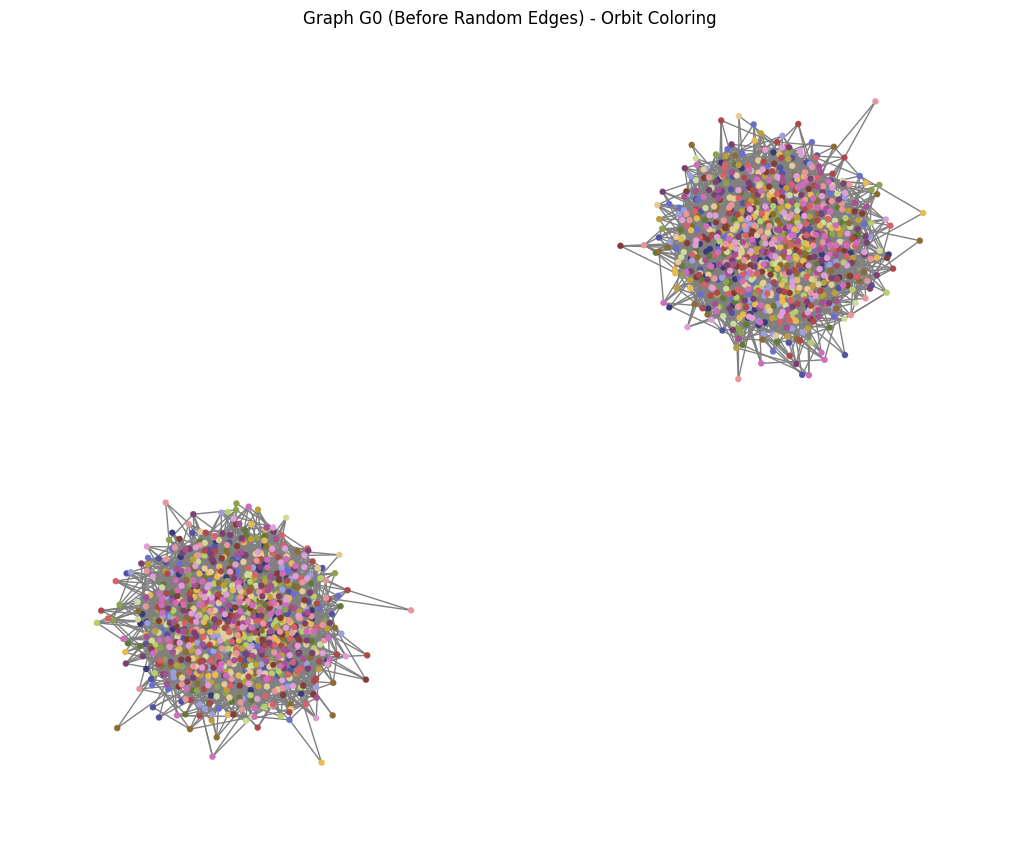

In [ ]:
# Visualization of G0 (before random edges)
pos = nx.spring_layout(G, seed=0)
orbit_colors_0 = [orbits_0[i] for i in range(len(orbits_0))]

plt.figure(figsize=(10, 8))
nx.draw(
    G0,
    pos,
    node_color=orbit_colors_0,
    cmap='tab20b',
    node_size=20,
    edge_color='gray',
    linewidths=0.1,
)
plt.title("Graph G0 (Before Random Edges) - Orbit Coloring")
plt.axis('off')
plt.show()

In [ ]:

# Step 3: Add 1000 uniformly random edges to G
possible_edges = list(itertools.combinations(range(2 * n), 2))
existing_edges = set(G.edges())
available_edges = list(set(possible_edges) - existing_edges)

random.seed(42)
random_edges = random.sample(available_edges, m_random_edges)
G.add_edges_from(random_edges)

print(f"Graph G: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Random edges added: {m_random_edges}")

# Optional: visualize a small subgraph
# sub_nodes = random.sample(G.nodes(), 100)
# sub_G = G.subgraph(sub_nodes)
# pos = nx.spring_layout(sub_G, seed=42)
# nx.draw(sub_G, pos, node_size=50, edge_color='gray')
# plt.title("Subgraph of G (randomly sampled)")
# plt.show()


--- Automorphism Comparison ---
Original Graph G0 (before random edges):
  Automorphism group size: 2.0
  Number of orbits: 1000

Modified Graph G1 (after 1000 random edges):
  Automorphism group size: 1.0
  Number of orbits: 2000


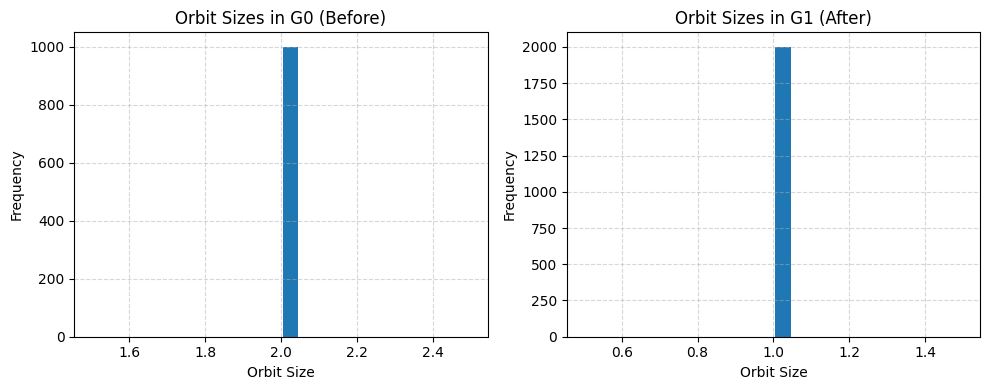